# Scalable Bayesian Modeling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/symeneses/SBM/blob/main/notebooks/template.ipynb)

In [ ]:
# Execute only if executing in Google Colab
# !rm -r ./src
# !git clone https://github.com/symeneses/SBM
# !mv ./SBM/src ./src
# !rm -r ./SBM
# !pip install numpyro

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

cores = os.cpu_count()
os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={cores}'
root_path = os.path.abspath(os.pardir)
if root_path not in sys.path:
    sys.path.append(root_path)

## Importing the needed libraries

In [2]:
import pandas as pd
import numpy as np
import numpyro
import pymc as pm

from src.handler import Handler
from src.diagnostics import dist_validator
from src.plots import plot_ess_ps

RANDOM_SEED = 8957


/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Getting the data

Create a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the variables to be used to define the model.

In [3]:
# Code to generate the data, name the final results as data
data = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
data["patient_codes"], _ = data["Patient"].factorize()

## Defining the model

In the following cells, write the code for the models you want to compare. To make comparing the models and results easier, use the same name of variables in each version of the model.

**For models in Numpyro:** Use the same variable names of the `DataFrame` `data` for the arguments of the function model. These arguments should contain only columns present in `data`.

In [4]:
patient_codes = data['patient_codes'].values
codes = np.unique(patient_codes)
coords = {"patients": codes}
weeks = data['Weeks']
FVC_obs = data['FVC']
with pm.Model(coords=coords) as pymc_model:

    mu_alpha = pm.Normal("μ_α", mu=0.0, sigma=500.0)
    sigma_alpha = pm.HalfNormal("σ_α", sigma=100.0)
    mu_beta = pm.Normal("μ_β", mu=0.0, sigma=3.0)
    sigma_beta = pm.HalfNormal("σ_β", sigma=3.0)

    alpha = pm.Normal("α", mu=mu_alpha, sigma=sigma_alpha, dims="patients")
    beta = pm.Normal("β", mu=mu_beta, sigma=sigma_beta, dims="patients")

    sigma = pm.HalfNormal("σ", sigma=100.0)

    FVC_est = alpha[data['patient_codes']] + beta[data['patient_codes']] * weeks

    y = pm.Normal("y", mu=FVC_est, sigma=sigma, observed=FVC_obs)


In [5]:
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


def model(patient_codes, Weeks, FVC=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_codes))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_codes] + β[patient_codes] * Weeks

    with numpyro.plate("data", len(patient_codes)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC)

numpyro_kernel = NUTS(model)

## Inference
Here, we will create create valid [InferenceData](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html) objects and a set of metrics to measure performance  for the selected models and samplers.

In [6]:
models = {"pymc": pymc_model, "numpyro": numpyro_kernel}
pymc_samplers = ["default", "numpyro", "blackjax"]
draws = 2000
tune = 2000
# It's recommended to use between 2 and 4 chains
chains = 2

# sampling all models
handler = Handler(models, data, pymc_samplers)
infer_data, results = handler.execute(draws, tune, chains, RANDOM_SEED)

Getting samples using libray pymc:


> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ_α, σ_α, μ_β, σ_β, α, β, σ]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.



> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:08.107708
Sampling...


Running chain 1: 100%|██████████| 4000/4000 [00:53<00:00, 74.90it/s] 


Sampling time =  0:00:55.686306
Transforming variables...
Transformation time =  0:00:00.099396

> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:07.170961
Sampling...
Sampling time =  0:00:18.300695
Transforming variables...
Transformation time =  0:00:47.040649
Getting samples using libray numpyro:



Running chain 1: 100%|██████████| 4000/4000 [00:29<00:00, 133.96it/s]


## Validate results 

To check that the models are sampling from the same distributions. The function `dist_validator` will estimate the ranges of the mean for each variable using the [MCSE](https://python.arviz.org/en/latest/api/generated/arviz.mcse.html) of one of the models as reference. The percentages displayed indicate how many variables are within the calculated range using ±3 sigma.
The values should be in theory greater or equal to `95%` following a weaker [three-sigma rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In [7]:
results_val, summaries = dist_validator(infer_data, seed=RANDOM_SEED)

Percentage of variables with the expected mean using MCSE:
> pymc_default    :  95.52% using pymc_numpyro as a random reference ✅
> pymc_numpyro    : 100.00% using pymc_numpyro as a random reference ✅
> pymc_blackjax   :  11.48% using pymc_numpyro as a random reference ❌
> numpyro_default :  96.64% using pymc_numpyro as a random reference ✅


## Comparison

### Resources metrics

In [8]:
results

,library,sampler,elapsed_time,current_memory,peak_memory
pymc_default,pymc,default,157.737284,38150875.0,63188437.0
pymc_numpyro,pymc,numpyro,64.062304,16994505.0,17152158.0
pymc_blackjax,pymc,blackjax,73.090621,19339463.0,19596942.0
numpyro_default,numpyro,default,32.990811,15754089.0,15851545.0


### ESS

To determine the sampler performance, we use the **Effective Sample Size** ([ESS](https://python.arviz.org/en/latest/api/generated/arviz.ess.html])) calculated per second.

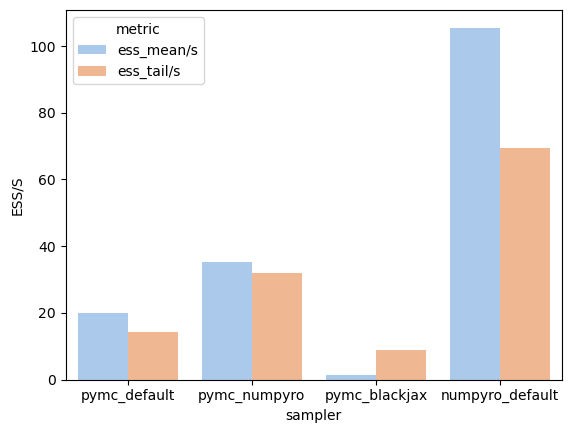

In [9]:
plot_ess_ps(results, summaries)